In [20]:
pip install cython


  Using cached cython-3.1.2-cp311-cp311-win_amd64.whl.metadata (6.0 kB)
Using cached cython-3.1.2-cp311-cp311-win_amd64.whl (2.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install -U setuptools


  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ax 0.52.0 requires graphql-ws<=0.3.0, but you have graphql-ws 0.4.4 which is incompatible.
ax 0.52.0 requires packaging<=20.1, but you have packaging 25.0 which is incompatible.
ax 0.52.0 requires python-dateutil<=2.8.1, but you have python-dateutil 2.9.0.post0 which is incompatible.
ax 0.52.0 requires ruamel.yaml<=0.16.7, but you have ruamel-yaml 0.18.10 which is incompatible.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.19.0 which is incompatible.


In [30]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install ibug

  Using cached ibug-0.0.11.tar.gz (369 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [25 lines of output]
      Traceback (most recent call last):
        File "C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
        File "C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_proces

In [22]:
pip install git+https://github.com/IBM/ibug.git


  Cloning https://github.com/IBM/ibug.git to c:\users\rafae\appdata\local\temp\pip-req-build-8notqzfb
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/IBM/ibug.git 'C:\Users\rafae\AppData\Local\Temp\pip-req-build-8notqzfb'
  fatal: User cancelled dialog.
  bash: line 1: /dev/tty: No such device or address
  error: failed to execute prompt script (exit code 1)
  fatal: could not read Username for 'https://github.com': No such file or directory
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/IBM/ibug.git 'C:\Users\rafae\AppData\Local\Temp\pip-req-build-8notqzfb' did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/IBM/ibug.git 'C:\Users\rafae\AppData\Local\Temp\pip-req-build-8notqzfb' did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is lik

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import os
import random
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from ibug import IBUGWrapper
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader



class GPR:
    def __init__(self, kernel=None, alpha=1.0, random_state=42):
        self.alpha = alpha
        self.kernel = kernel if kernel else (
            C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
            WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e6))
        )
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def select_next_point(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        ucb = mean + self.alpha * std
        return np.argmax(ucb), ucb, mean, std

class RFR:
    def __init__(self,n_estimators=400, random_state=42):
        self.model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def rfPredictionIntervals(self, xVal, percentile=90):
        # initialize a list to hold the predictions from each tree
        y_preds = []
        # loop through the trees in the random forest
        for tree in self.model.estimators_:
            # get the predictions from each tree
            y_pred = tree.predict(xVal)
            # append the predictions to the list
            y_preds.append(y_pred)
        # Convert to np.array by stacking list of arrays along the column axis with each column being the prediction from a different tree
        y_preds = np.stack(y_preds, axis=1)           
        # get the quantiles for the confidence interval
        q_down = (100 - percentile) / 2.
        q_up = 100 - q_down

        # get the mean, uncertainty, lower bound, and upper bound
        y_lower = np.percentile(y_preds, q_down, axis=1)
        y_upper = np.percentile(y_preds, q_up, axis=1)  
        y_mean = self.model.predict(xVal)  
        y_uncert = y_upper - y_lower
        
        return y_mean, y_uncert


    def select_next_point(self, X_candidates):
        mean, uncertainty = self.rfPredictionIntervals(X_candidates)
        return np.argmax(uncertainty), mean, uncertainty



#class XGB_MaxUncertainty:
#    def __init__(self, n_estimators=400):
#        self.base_model = XGBRegressor(n_estimators=n_estimators,reg_alpha=0,scale_pos_weight=1,base_score=0.5)
#        self.ibug_model= IBUGWrapper()

#    def update_model(self, X_train, y_train):
#        self.base_model.fit(X_train, y_train)

#    def select_next_point(self, X_train, y_train,xVal):
#        # Predict with uncertainty using IBUG
#        self.update_model(X_train,y_train)
#        self.ibug_model.fit(self.base_model,X_train, y_train)
#        self.ibug_model.set_tree_subsampling(1.0, 'random')
#        meansXGBOOST,varXGBOOST= self.ibug_model.pred_dist(xVal)
#        std_XGBOOST= np.sqrt(varXGBOOST)

#        return  np.argmax(std_XGBOOST),meansXGBOOST, std_XGBOOST


# Second option
class XGB:
    def __init__(self, n_estimators=400, n_models=30, random_state=42):
        self.n_models = n_models
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def update_model(self, X_train, y_train):
        self.models = []
        rng = np.random.RandomState(self.random_state)
        for i in range(self.n_models):
            X_sample, y_sample = resample(X_train, y_train, random_state=rng.randint(0, 10000))
            model = XGBRegressor(
                n_estimators=self.n_estimators,
                reg_alpha=0,
                scale_pos_weight=1,
                base_score=0.5,
                random_state=rng.randint(0, 10000)
            )
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def select_next_point(self, X_candidates):
        # Predict with all models
        y_preds = np.column_stack([model.predict(X_candidates) for model in self.models])

        # Compute uncertainty and mean
        y_mean = np.mean(y_preds, axis=1)
        y_std = np.std(y_preds, axis=1)

        # Select point with highest uncertainty
        next_idx = np.argmax(y_std)
        return next_idx, y_mean, y_std


#-------------------------------------------------------------------------------- BAYESIAN NEURAL NETWORK -------------------------------------------------------------------------------------------
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Variational parameters for weights and biases
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-5.0))

        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(out_features).fill_(-5.0))

        # Prior
        self.prior = Normal(0, 1)
        self.normal = Normal(0, 1)

#    def forward(self, x):
        # Reparameterization trick
#        weight_sigma = torch.exp(self.weight_log_sigma)
#        bias_sigma = torch.exp(self.bias_log_sigma)

#        weight = self.weight_mu + weight_sigma * self.normal.sample(self.weight_mu.shape).to(x.device)
#        bias = self.bias_mu + bias_sigma * self.normal.sample(self.bias_mu.shape).to(x.device)

#        return F.linear(x, weight, bias)

    def forward(self, x):
        device = x.device

        weight_sigma = torch.exp(self.weight_log_sigma)
        bias_sigma = torch.exp(self.bias_log_sigma)

        # Create ε ~ N(0, 1) on the correct device
        weight_eps = torch.randn_like(self.weight_mu, device=device)
        bias_eps = torch.randn_like(self.bias_mu, device=device)

        weight = self.weight_mu + weight_sigma * weight_eps
        bias = self.bias_mu + bias_sigma * bias_eps

        return F.linear(x, weight, bias)


    def kl_loss(self):
        # Posterior: N(mu, sigma^2), Prior: N(0, 1)
        weight_sigma = torch.exp(self.weight_log_sigma)
        bias_sigma = torch.exp(self.bias_log_sigma)

        weight_kl = (torch.log(1.0 / weight_sigma) + (weight_sigma ** 2 + self.weight_mu ** 2 - 1) / 2).sum()
        bias_kl = (torch.log(1.0 / bias_sigma) + (bias_sigma ** 2 + self.bias_mu ** 2 - 1) / 2).sum()
        return weight_kl + bias_kl


class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.layers = nn.ModuleList([
            BayesianLinear(input_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
        ])
        self.out = BayesianLinear(hidden_dim, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.out(x)

    def kl_loss(self):
        return sum(layer.kl_loss() for layer in self.layers) + self.out.kl_loss()


def elbo_loss(predictions, targets, kl, beta=1.0):
    mse = F.mse_loss(predictions.squeeze(), targets, reduction='mean')
    return mse + beta * kl


def train_bnn(model, X_train, y_train, n_epochs=1000, lr=1e-3, beta=1.0, batch_size=64, device='cpu'):
    # Create DataLoader for batching
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        total_kl = 0.0
        total_batches = 0

        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            kl = model.kl_loss()
            loss = elbo_loss(preds, y_batch, kl, beta)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_kl += kl.item()
            total_batches += 1

        if epoch % 100 == 0:
            avg_loss = total_loss / total_batches
            avg_kl = total_kl / total_batches
            print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Avg KL: {avg_kl:.2f}")


def predict_with_uncertainty(model, X, n_samples=1000):
    model.eval()
    #with torch.no_grad():
    preds = torch.stack([model(X).detach().squeeze() for _ in range(n_samples)])

    mean = preds.mean(0).cpu().numpy()
    std = preds.std(0).cpu().numpy()
    return mean, std

#-------------------------------------------------------------------------------- END CODE BAYESIAN NEURAL NETWORK -------------------------------------------------------------------------------------------




class BNN:
    def __init__(self, input_dim,device='cpu'):
        self.device=device
        self.model= BayesianNN(input_dim=input_dim).to(self.device)

    def update_model(self, X_train, y_train):
        X_train_tensor=torch.from_numpy(X_train).float().to(self.device)
        y_train_tensor=torch.from_numpy(y_train).float().to(self.device)
        train_bnn(self.model,X_train_tensor, y_train_tensor, batch_size=64,device=self.device)

    def select_next_point(self, X_candidates):
        X_candidates_tensor=torch.from_numpy(X_candidates).float().to(self.device)
        mean, std = predict_with_uncertainty(self.model,X_candidates_tensor)
        return np.argmax(std), mean, std





def run_gpr_experiment_matbench_steels_featurized(X_df, y_df, model_name, target_name, dataset_name, alpha=1.0, random_seed=42):
    X = X_df.values
    y = y_df.values
    max_target = y.max()

    num_col=X.shape[1]

    random.seed(random_seed)
    np.random.seed(random_seed)

    initial_idx = random.choice(list(range(len(X))))
    X_train_GPR = X[[initial_idx]]
    y_train_GPR = np.array([y[initial_idx]])
    X_train_RFR = X_train_GPR.copy()
    y_train_RFR = y_train_GPR.copy()
    X_train_XGB = X_train_GPR.copy()
    y_train_XGB = y_train_GPR.copy()
    X_train_BNN = X_train_GPR.copy()
    y_train_BNN = y_train_GPR.copy()


    model_GPR = GPR(alpha=alpha, random_state=random_seed)
    model_RFR = RFR(alpha=alpha, random_state=random_seed)
    model_XGB = XGB(alpha=alpha, random_state=random_seed)
    model_BNN = BNN(num_col, alpha=alpha, device='cuda' if torch.cuda.is_available() else 'cpu')

    
    model_GPR.update_model(X_train_GPR, y_train_GPR)
    model_RFR.update_model(X_train_RFR, y_train_RFR)
    model_XGB.update_model(X_train_XGB,y_train_XGB)
    model_BNN.update_model(X_train_BNN, y_train_BNN)



    # Indices of selected points
    selected_GPR = [initial_idx]
    selected_RFR = [initial_idx]
    selected_XGB = [initial_idx]
    selected_BNN = [initial_idx] 

    # Observed values
    observed_GPR = [y[initial_idx]]
    observed_RFR = [y[initial_idx]]
    observed_XGB = [y[initial_idx]]
    observed_BNN = [y[initial_idx]] 

    # Mean predictions over all candidates
    mean_predictions_GPR = []
    mean_predictions_RFR = []
    mean_predictions_XGB = []
    mean_predictions_BNN = []  

    # Uncertainty estimates
    std_predictions_GPR = []
    uncertaintites_RFR = []
    uncertaintites_XGB = []
    uncertaintites_BNN = [] 


    iteration_indices = [0]
    trajectory_data = []

    for i, _ in enumerate(range(len(X) - 1)):
        scaler_GPR = StandardScaler()
        scaler_RFR = StandardScaler()
        scaler_XGB = StandardScaler()
        scaler_BNN = StandardScaler()
        X_train_scaled_GPR = scaler_GPR.fit_transform(X_train_GPR)
        X_train_scaled_RFR = scaler_RFR.fit_transform(X_train_RFR)
        X_train_scaled_XGB = scaler_XGB.fit_transform(X_train_XGB)
        X_train_scaled_BNN = scaler_BNN.fit_transform(X_train_BNN)

        model_GPR.update_model(X_train_scaled_GPR, y_train_GPR)
        model_RFR.update_model(X_train_scaled_RFR, y_train_RFR)
        model_XGB.update_model(X_train_scaled_XGB, y_train_XGB)
        model_BNN.update_model(X_train_scaled_BNN, y_train_BNN)

        available_GPR = list(set(range(len(X))) - set(selected_GPR))
        available_RFR = list(set(range(len(X))) - set(selected_RFR))
        available_XGB = list(set(range(len(X))) - set(selected_XGB))
        available_BNN = list(set(range(len(X))) - set(selected_BNN)) 

        X_candidates_scaled_GPR = scaler_GPR.transform(X[available_GPR])
        X_candidates_scaled_RFR = scaler_RFR.transform(X[available_RFR])
        X_candidates_scaled_XGB = scaler_XGB.transform(X[available_XGB])
        X_candidates_scaled_BNN = scaler_BNN.transform(X[available_BNN])

        #----------------------------------------------------------------- UCB-------------------------------------------------------------------
        idx_GPR, ucb_scores_GPR, mean_GPR, std_GPR = model_GPR.select_next_point(X_candidates_scaled_GPR)
        next_idx_GPR = available_GPR[idx_GPR]
        selected_GPR.append(next_idx_GPR)
        observed_GPR.append(y[next_idx_GPR])
        X_train_GPR = np.vstack([X_train_GPR, X[[next_idx_GPR]]])
        y_train_GPR = np.append(y_train_GPR, y[next_idx_GPR])
        

        #-----------------------------------------------------------------RF MAX UNCERTAINTY-------------------------------------------------------------------
        idx_RFR, mean_RFR, uncertainty_RFR = model_RFR.select_next_point(X_candidates_scaled_RFR)
        next_idx_RFR = available_RFR[idx_RFR]
        selected_RFR.append(next_idx_RFR)
        observed_RFR.append(y[next_idx_RFR])
        X_train_RFR = np.vstack([X_train_RFR, X[[next_idx_RFR]]])
        y_train_RFR = np.append(y_train_RFR, y[next_idx_RFR])

        
        #-----------------------------------------------------------------XGBOOST MAX UNCERTAINTY-------------------------------------------------------------------
        # IBUG FOR XGBOOST NEEDS AT LEAST 2 POINTS, FOR THE FIRST ITERATION, WE TAKE THE SAME OUTPUT AS IF WE WERE RUNNING RF

        #if i>=1:
        #    idx_XGmaxu, mean_XGmaxu, uncertainty_XGmaxu=model_XGBOOST_max.select_next_point(X_train_XG_maxu,y_train_XG_maxu,X_candidates)
        #    next_idx_xgmaxu=available[idx_XGmaxu]
        #else:
        #    idx_XGmaxu, mean_XGmaxu, uncertainty_XGmaxu=idx_RFmaxu, mean_RFmaxu, uncertainty_RFmaxu
        #    next_idx_xgmaxu=available[idx_RFmaxu]
        
        
        idx_XGB, mean_XGB, uncertainty_XGB = model_XGB.select_next_point(X_candidates_scaled_XGB)
        next_idx_XGB = available_XGB[idx_XGB]
        selected_XGB.append(next_idx_XGB)
        observed_XGB.append(y[next_idx_XGB])
        X_train_XGB = np.vstack([X_train_XGB, X[[next_idx_XGB]]])
        y_train_XGB = np.append(y_train_XGB, y[next_idx_XGB])

        #-----------------------------------------------------------------NN MAX UNCERTAINTY-------------------------------------------------------------------

        idx_BNN, mean_BNN, uncertainty_BNN = model_BNN.select_next_point(X_candidates_scaled_BNN)
        next_idx_BNN = available_BNN[idx_BNN]
        selected_BNN.append(next_idx_BNN)
        observed_BNN.append(y[next_idx_BNN])
        X_train_BNN = np.vstack([X_train_BNN, X[[next_idx_BNN]]])
        y_train_BNN = np.append(y_train_BNN, y[next_idx_BNN])



        mean_predictions_GPR.append(mean_GPR[idx_GPR])
        mean_predictions_RFR.append(mean_RFR[idx_RFR])
        mean_predictions_XGB.append(mean_XGB[idx_XGB])
        mean_predictions_BNN.append(mean_BNN[idx_BNN])


        std_predictions_GPR.append(std_GPR[idx_GPR])
        uncertaintites_RFR.append(uncertainty_RFR[idx_RFR])
        uncertaintites_XGB.append(uncertainty_XGB[idx_XGB])
        uncertaintites_BNN.append(uncertainty_BNN[idx_BNN])
        
        iteration_indices.append(i+1)

        trajectory_data.append({
            "Iteration": i+1,
            "GPR Index": next_idx_GPR,
            "GPR Observed": y[next_idx_GPR],
            "GPR Predicted": mean_GPR[idx_GPR],
            "GPR Uncertainty": std_GPR[idx_GPR],
            "RFR Index": next_idx_RFR,
            "RFR Observed": y[next_idx_RFR],
            "RFR Predicted": mean_RFR[idx_RFR],
            "RFR Uncertainty": uncertainty_RFR[idx_RFR],
            "XGB Index": next_idx_XGB,
            "XGB Observed": y[next_idx_XGB],
            "XGB Predicted": mean_XGB[idx_XGB],
            "XGB Uncertainty": uncertainty_XGB[idx_XGB],
            "BNN Index": next_idx_BNN,
            "BNN Observed": y[next_idx_BNN],
            "BNN Predicted": mean_BNN[idx_BNN],
            "BNN Uncertainty": uncertainty_BNN[idx_BNN],
            f"Max {target_name} in Dataset": max_target,
            "Stopping Reason": f"Max {target_name} reached" if y[next_idx_GPR] >= max_target or y[next_idx_RFR] >= max_target or y[next_idx_XGB] >= max_target or y[next_idx_BNN] >= max_target else "Continuing"
        })

        if y[next_idx_ucb] >= max_strength or y[next_idx_ei] >= max_strength or y[next_idx_rfmaxu] >= max_strength or y[next_idx_xgmaxu] >= max_strength or y[next_idx_nnmaxu] >= max_strength :
            print(f"Stopping early at iteration {i+1} - Max yield strength found.")
            break

    df_traj = pd.DataFrame(trajectory_data)
    os.makedirs("al_trajectory_data_matbench_steels", exist_ok=True)
    file_path = f"al_trajectory_data_matbench_steels/gpr_experiment_trajectory_matbench_steels_featurized_alpha{alpha}_seed{random_seed}.csv"
    df_traj.to_csv(file_path, index=False)
    print(f"Saved trajectory data to {file_path}")

    # Plotting
    plt.figure(figsize=(20, 12))
    plt.plot(range(len(obs_ucb)), obs_ucb, marker='o', label=f"Observed with UCB (alpha={alpha})")
    plt.plot(range(len(obs_ei)), obs_ei, marker='s', label=f"Observed with Expected Improvement (xi={xi})")
    plt.plot(range(len(obs_rf_maxU)), obs_rf_maxU, marker='d', label="Observed with Maximum Uncertainty RF")
    plt.plot(range(len(obs_XG_maxU)), obs_XG_maxU, marker='*', label="Observed with Maximum Uncertainty XGBOOST")
    plt.plot(range(len(obs_XG_maxU)), obs_NN_maxU, marker='^', label="Observed with Maximum Uncertainty NN")




    plt.fill_between(iteration_indices[1:], np.array(mean_predictions_ei) - np.array(std_predictions_ei),
                     np.array(mean_predictions_ei) + np.array(std_predictions_ei),
                     color="blue", alpha=0.3, label="Uncertainty EI")
    plt.plot(iteration_indices[1:], mean_predictions_ei, linestyle='--', color="blue", label="Predicted Strength using EI")




    plt.fill_between(iteration_indices[1:], np.array(mean_predictions_ucb) - np.array(std_predictions_ucb),
                     np.array(mean_predictions_ucb) + np.array(std_predictions_ucb),
                     color="gray", alpha=0.3, label="Uncertainty UCB")
    plt.plot(iteration_indices[1:], mean_predictions_ucb, linestyle='--', color="gray", label="Predicted Strength using UCB")




    plt.fill_between(iteration_indices[1:], np.array(mean_predictions_rf_maxu) - np.array(uncertaintites_rf_maxu),
                     np.array(mean_predictions_rf_maxu) + np.array(uncertaintites_rf_maxu),
                     color="green", alpha=0.3, label="Uncertainty  RF")
    plt.plot(iteration_indices[1:], mean_predictions_rf_maxu, linestyle='--', color="green", label="Predicted Strenght  using RF")




    
    plt.fill_between(iteration_indices[1:], np.array(mean_predictions_XG_maxu) - np.array(uncertaintites_XG_maxu),
                     np.array(mean_predictions_XG_maxu) + np.array(uncertaintites_XG_maxu),
                     color="red", alpha=0.3, label="Uncertainty XGBOOST")
    plt.plot(iteration_indices[1:], mean_predictions_XG_maxu, linestyle='--', color="red", label="Predicted Strengt using XGBOOST")



    plt.fill_between(
    iteration_indices[1:],
    np.array(mean_predictions_NN_maxu) - np.array(uncertaintites_NN_maxu),
    np.array(mean_predictions_NN_maxu) + np.array(uncertaintites_NN_maxu),
    color="magenta", alpha=0.3, label="Uncertainty NN"
    )

    plt.plot(
    iteration_indices[1:],
    mean_predictions_NN_maxu,
    linestyle='--', color="magenta", label="Predicted Strength using NN"
    )
    


    plt.axhline(max_strength, color='r', linestyle='--', label='Max Yield Strength')
    plt.xlabel("Iteration")
    plt.ylabel("Yield Strength")
    plt.title(f"Comparison of UCB and EI for Active Learning (Seed={random_seed})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

data_grouped = pd.read_csv(r'c:\Users\rafae\Downloads\steels_yield_report_featurized.csv')

for alpha in [0, 0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5]:
    for seed in [42, 41, 40, 39, 38]:
        run_gpr_experiment_matbench_steels_featurized(data_grouped, alpha=alpha, random_seed=seed)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import os
import random
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from ibug import IBUGWrapper
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
# ignore warnings
import warnings
warnings.filterwarnings("ignore")



class GPR:
    def __init__(self, kernel=None, alpha=1.0, random_state=42):
        self.alpha = alpha
        self.kernel = kernel if kernel else (
            C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
            WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e6))
        )
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def select_next_point(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        ucb = mean + self.alpha * std
        return np.argmax(ucb), ucb, mean, std

class RFR:
    def __init__(self,n_estimators=400, alpha=1.0, random_state=42):
        self.alpha = alpha
        self.model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def rfPredictionIntervals(self, xVal, percentile=90):
        # initialize a list to hold the predictions from each tree
        y_preds = []
        # loop through the trees in the random forest
        for tree in self.model.estimators_:
            # get the predictions from each tree
            y_pred = tree.predict(xVal)
            # append the predictions to the list
            y_preds.append(y_pred)
        # Convert to np.array by stacking list of arrays along the column axis with each column being the prediction from a different tree
        y_preds = np.stack(y_preds, axis=1)           
        # get the quantiles for the confidence interval
        q_down = (100 - percentile) / 2.
        q_up = 100 - q_down

        # get the mean, uncertainty, lower bound, and upper bound
        y_lower = np.percentile(y_preds, q_down, axis=1)
        y_upper = np.percentile(y_preds, q_up, axis=1)  
        y_mean = self.model.predict(xVal)  
        y_uncert = y_upper - y_lower
        
        return y_mean, y_uncert


    def select_next_point(self, X_candidates):
        mean, uncertainty = self.rfPredictionIntervals(X_candidates)
        ucb = mean + self.alpha * uncertainty
        return np.argmax(ucb), ucb, mean, uncertainty

class XGB:
    def __init__(self, n_estimators=400, n_models=30, alpha = 1.0, random_state=42):
        self.alpha = alpha
        self.n_models = n_models
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def update_model(self, X_train, y_train):
        self.models = []
        rng = np.random.RandomState(self.random_state)
        for i in range(self.n_models):
            X_sample, y_sample = resample(X_train, y_train, random_state=rng.randint(0, 10000))
            model = XGBRegressor(
                n_estimators=self.n_estimators,
                reg_alpha=0,
                scale_pos_weight=1,
                base_score=0.5,
                random_state=rng.randint(0, 10000)
            )
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def select_next_point(self, X_candidates):
        # Predict with all models
        y_preds = np.column_stack([model.predict(X_candidates) for model in self.models])

        # Compute uncertainty and mean
        y_mean = np.mean(y_preds, axis=1)
        y_std = np.std(y_preds, axis=1)
        ucb = y_mean + self.alpha * y_std
        return np.argmax(ucb), ucb, y_mean, y_std


#-------------------------------------------------------------------------------- BAYESIAN NEURAL NETWORK -------------------------------------------------------------------------------------------
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Variational parameters for weights and biases
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-5.0))

        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(out_features).fill_(-5.0))

        # Prior
        self.prior = Normal(0, 1)
        self.normal = Normal(0, 1)

#    def forward(self, x):
        # Reparameterization trick
#        weight_sigma = torch.exp(self.weight_log_sigma)
#        bias_sigma = torch.exp(self.bias_log_sigma)

#        weight = self.weight_mu + weight_sigma * self.normal.sample(self.weight_mu.shape).to(x.device)
#        bias = self.bias_mu + bias_sigma * self.normal.sample(self.bias_mu.shape).to(x.device)

#        return F.linear(x, weight, bias)

    def forward(self, x):
        device = x.device

        weight_sigma = torch.exp(self.weight_log_sigma)
        bias_sigma = torch.exp(self.bias_log_sigma)

        # Create ε ~ N(0, 1) on the correct device
        weight_eps = torch.randn_like(self.weight_mu, device=device)
        bias_eps = torch.randn_like(self.bias_mu, device=device)

        weight = self.weight_mu + weight_sigma * weight_eps
        bias = self.bias_mu + bias_sigma * bias_eps

        return F.linear(x, weight, bias)


    def kl_loss(self):
        # Posterior: N(mu, sigma^2), Prior: N(0, 1)
        weight_sigma = torch.exp(self.weight_log_sigma)
        bias_sigma = torch.exp(self.bias_log_sigma)

        weight_kl = (torch.log(1.0 / weight_sigma) + (weight_sigma ** 2 + self.weight_mu ** 2 - 1) / 2).sum()
        bias_kl = (torch.log(1.0 / bias_sigma) + (bias_sigma ** 2 + self.bias_mu ** 2 - 1) / 2).sum()
        return weight_kl + bias_kl


class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.layers = nn.ModuleList([
            BayesianLinear(input_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
            BayesianLinear(hidden_dim, hidden_dim),
        ])
        self.out = BayesianLinear(hidden_dim, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.out(x)

    def kl_loss(self):
        return sum(layer.kl_loss() for layer in self.layers) + self.out.kl_loss()


def elbo_loss(predictions, targets, kl, beta=1.0):
    mse = F.mse_loss(predictions.squeeze(), targets, reduction='mean')
    return mse + beta * kl


def train_bnn(model, X_train, y_train, n_epochs=1000, lr=1e-3, beta=1.0, batch_size=64, device='cpu'):
    # Create DataLoader for batching
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        total_kl = 0.0
        total_batches = 0

        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            kl = model.kl_loss()
            loss = elbo_loss(preds, y_batch, kl, beta)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_kl += kl.item()
            total_batches += 1

        if epoch % 100 == 0:
            avg_loss = total_loss / total_batches
            avg_kl = total_kl / total_batches
            print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Avg KL: {avg_kl:.2f}")


def predict_with_uncertainty(model, X, n_samples=1000):
    model.eval()
    #with torch.no_grad():
    preds = torch.stack([model(X).detach().squeeze() for _ in range(n_samples)])

    mean = preds.mean(0).cpu().numpy()
    std = preds.std(0).cpu().numpy()
    return mean, std

#-------------------------------------------------------------------------------- END CODE BAYESIAN NEURAL NETWORK -------------------------------------------------------------------------------------------


class BNN:
    def __init__(self, input_dim,device='cpu', alpha=1.0):
        self.alpha = alpha
        self.device=device
        self.model= BayesianNN(input_dim=input_dim).to(self.device)

    def update_model(self, X_train, y_train):
        X_train_tensor=torch.from_numpy(X_train).float().to(self.device)
        y_train_tensor=torch.from_numpy(y_train).float().to(self.device)
        train_bnn(self.model,X_train_tensor, y_train_tensor, batch_size=64,device=self.device)

    def select_next_point(self, X_candidates):
        X_candidates_tensor=torch.from_numpy(X_candidates).float().to(self.device)
        mean, std = predict_with_uncertainty(self.model,X_candidates_tensor)
        ucb = mean + self.alpha * std
        return np.argmax(ucb), ucb, mean, std





def run_MLAL(X_df, y_df, model_name, target_name, dataset_name, alpha=1.0, random_seed=42):
    X = X_df.values
    y = y_df.values
    max_target = y.max()

    num_col=X.shape[1]

    random.seed(random_seed)
    np.random.seed(random_seed)

    initial_idx = random.choice(list(range(len(X))))
    X_train = X[[initial_idx]]
    y_train = np.array([y[initial_idx]])

    if model_name == "GPR":
        model = GPR(alpha=alpha, random_state=random_seed)
    elif model_name == "RFR":
        model = RFR(alpha=alpha, random_state=random_seed)
    elif model_name == "XGB":
        model = XGB(alpha=alpha, random_state=random_seed)
    elif model_name == "BNN":
        model = BNN(num_col, alpha=alpha, device='cuda' if torch.cuda.is_available() else 'cpu')
    else:
        raise ValueError("Invalid model name. Choose from 'GPR', 'RFR', 'XGB', or 'BNN'.")
    
    model.update_model(X_train, y_train)

    # Indices of selected points
    selected = [initial_idx]
    # Observed values
    observed = [y[initial_idx]]
    # Mean predictions over all candidates
    mean_predictions = []
    # Uncertainty estimates
    uncertaintites = []

    iteration_indices = [0]
    trajectory_data = []

    for i, _ in enumerate(range(len(X) - 1)):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        model.update_model(X_train_scaled, y_train)

        available = list(set(range(len(X))) - set(selected))

        X_candidates_scaled = scaler.transform(X[available])

        #----------------------------------------------------------------- UCB-------------------------------------------------------------------
        idx, ucb_scores, mean, uncertaintity = model.select_next_point(X_candidates_scaled)
        next_idx = available[idx]
        selected.append(next_idx)
        observed.append(y[next_idx])
        X_train = np.vstack([X_train, X[[next_idx]]])
        y_train= np.append(y_train, y[next_idx])

        mean_predictions.append(mean[idx])
        uncertaintites.append(uncertaintity[idx])

        iteration_indices.append(i+1)

        trajectory_data.append({
            "Iteration": i+1,
            "Index": next_idx,
            "Observed Target Value": y[next_idx],
            "Predicted Target Value": mean[idx],
            "Uncertainty": uncertaintity[idx],
            f"Max {target_name} in Dataset": max_target,
            "Stopping Reason": f"Max {target_name} reached" if y[next_idx] >= max_target else "Continuing"
        })

        if y[next_idx] >= max_target:
            print(f"Stopping early at iteration {i+1} - Max {target_name} found.")
            break

    df_traj = pd.DataFrame(trajectory_data)
    os.makedirs(f"al_trajectory_data_all", exist_ok=True)
    file_path = f"al_trajectory_data_all/{dataset_name}/{model_name}_trajectory_{dataset_name}_alpha{alpha}_seed{random_seed}.csv"
    df_traj.to_csv(file_path, index=False)
    print(f"Saved trajectory data to {file_path}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(observed)), observed, marker='o', label=f"Observed with {model_name} (alpha={alpha})")
    plt.fill_between(iteration_indices[1:], np.array(mean_predictions) - np.array(uncertaintites),
                     np.array(mean_predictions) + np.array(uncertaintites),
                     color="gray", alpha=0.3, label=f"Uncertainty {model_name}")
    plt.plot(iteration_indices[1:], mean_predictions, linestyle='--', color="gray", label=f"Predicted Strength using {model_name}")


    plt.axhline(max_target, color='r', linestyle='--', label=f'Max {target_name}')
    plt.xlabel("Iteration")
    plt.ylabel(target_name)
    plt.title(f"{model_name} Active Learning Trajectory (Alpha = {alpha}; Seed={random_seed})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
data_grouped = pd.read_csv('steels_yield_report_featurized.csv')
X_df = data_grouped.drop(columns=['composition_original','yield strength','Report', 'Report with output', 'Formatted_Parameters'], errors='ignore')
X_df = X_df.select_dtypes(include=[np.number]).iloc[:, 14:]
y_df = data_grouped['yield strength']

Stopping early at iteration 21 - Max Yield Strength found.
Saved trajectory data to al_trajectory_data_all/matbench_steels/GPR_trajectory_matbench_steels_alpha2_seed42.csv


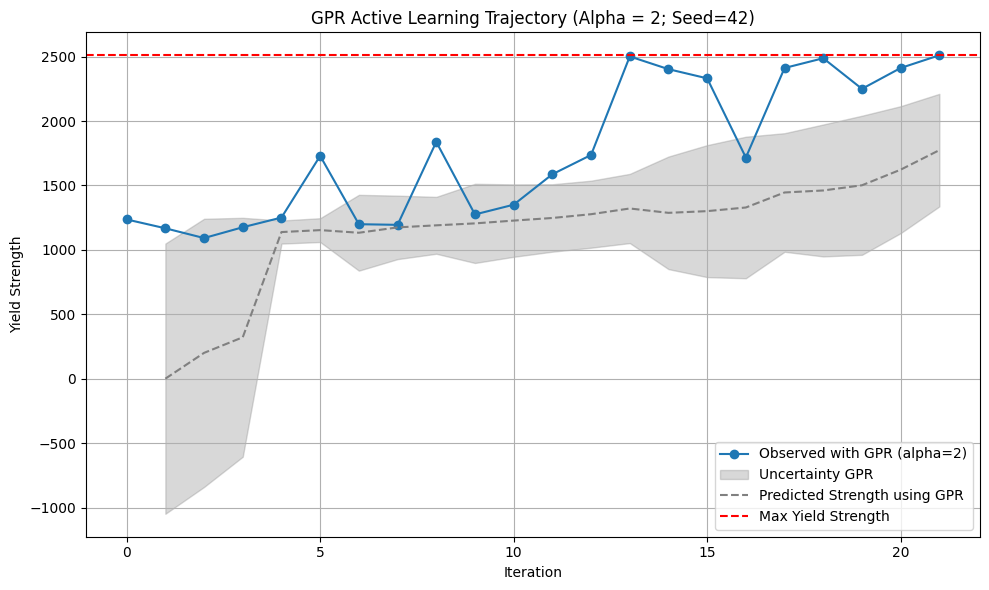

Stopping early at iteration 57 - Max Yield Strength found.
Saved trajectory data to al_trajectory_data_all/matbench_steels/GPR_trajectory_matbench_steels_alpha2_seed41.csv


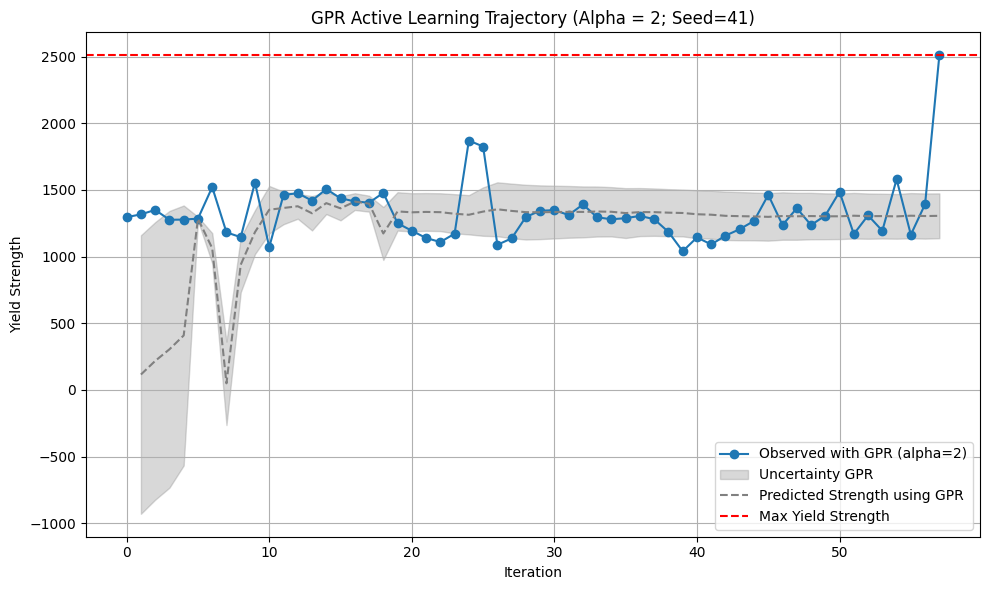

Stopping early at iteration 35 - Max Yield Strength found.
Saved trajectory data to al_trajectory_data_all/matbench_steels/GPR_trajectory_matbench_steels_alpha2_seed40.csv


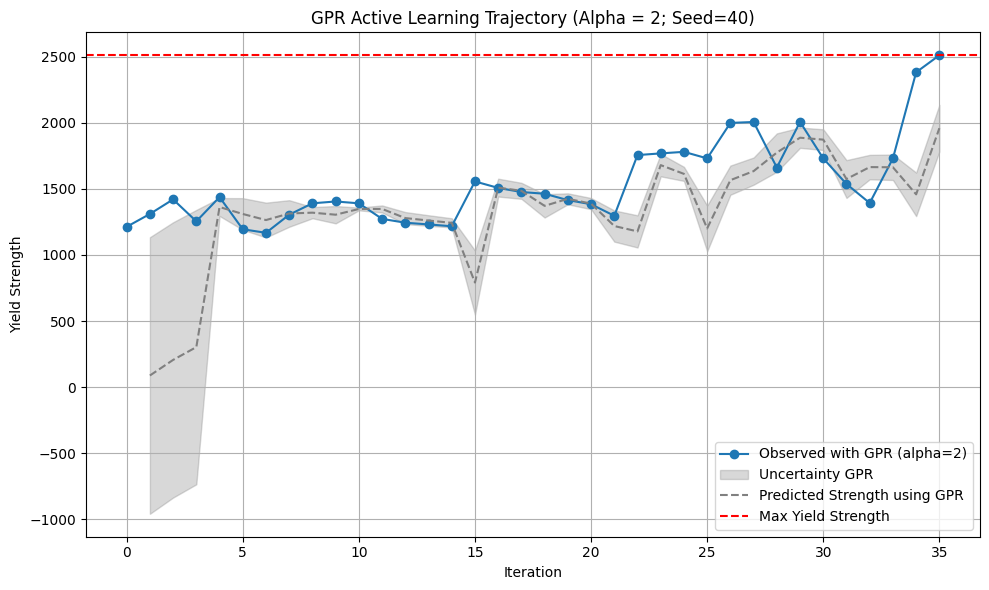

Stopping early at iteration 37 - Max Yield Strength found.
Saved trajectory data to al_trajectory_data_all/matbench_steels/GPR_trajectory_matbench_steels_alpha2_seed39.csv


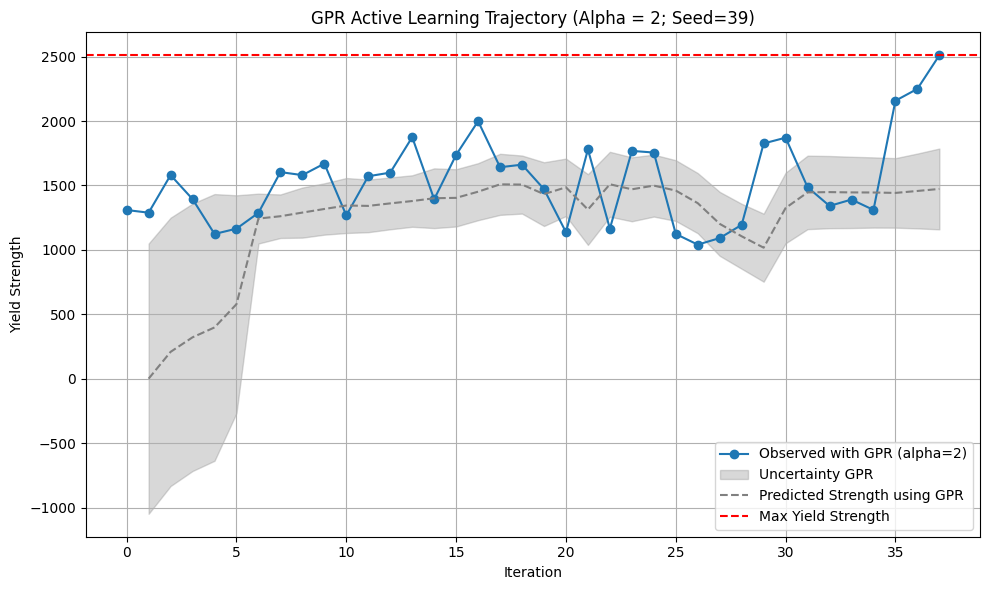

Stopping early at iteration 104 - Max Yield Strength found.
Saved trajectory data to al_trajectory_data_all/matbench_steels/GPR_trajectory_matbench_steels_alpha2_seed38.csv


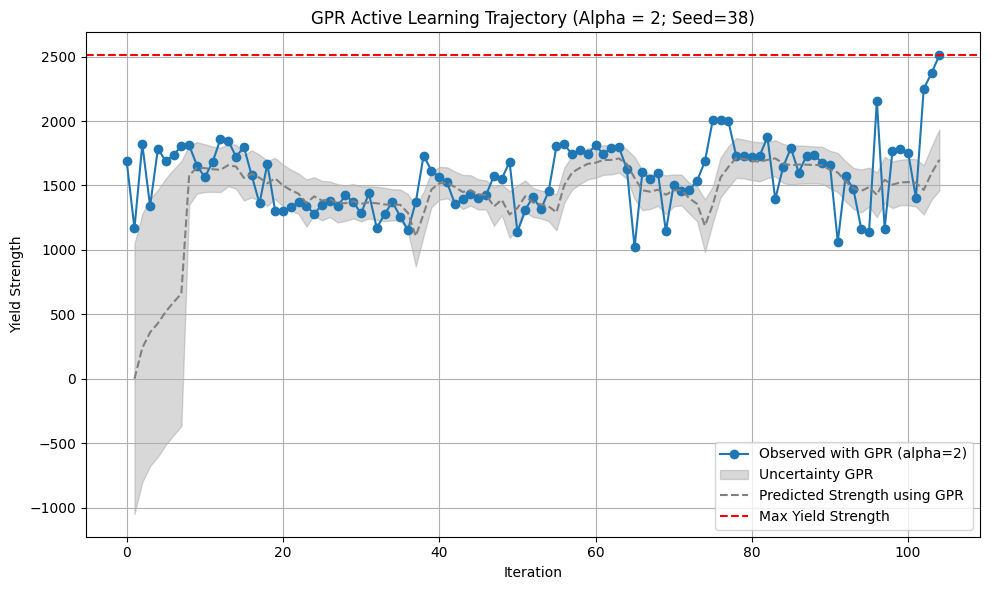

In [13]:
for alpha in [2]:
    for seed in [42, 41, 40, 39, 38]:
        run_MLAL(X_df, y_df, model_name="GPR", target_name="Yield Strength", dataset_name="matbench_steels", alpha=alpha, random_seed=seed)